In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
# import kuaizi
import torch
from torch import Tensor

In [3]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, interp_nan

In [5]:
dlambda_spec = 2
wave_lo = 2000 # 1000
wave_hi = 15000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [6]:
## Load the NN emulator `speculator`
with open('./speculator_best_loss_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [22]:
params = np.concatenate([np.load(f'./train_sed/fsps.TZD.v0.1.theta.seed{i+1}.npy')
                         for i in range(5)])
params[:, 1] = np.log10(params[:, 1])
params[:, -2] = np.log10(params[:, -2])

log_spec = np.concatenate([np.load(f'./train_sed/fsps.TZD.v0.1.log10spectrum.seed{i+1}.npy')
                           for i in range(5)])
log_spec = interp_nan(log_spec)[:, 500:]
# Very large... and slow

zero_flag = (np.mean(log_spec, axis=1) < -30)
log_spec = log_spec[~zero_flag]
params = params[~zero_flag]
pca_coeff = np.load('./train_sed/fsps.pca_coeffs.npy')[~zero_flag]
# # This zero_flag is SUPER IMPORTANT!!!

In [23]:
params = params[10000:20000]
log_spec = log_spec[10000:20000]
pca_coeff = pca_coeff[10000:20000]

In [24]:
_specs = speculator._predict_spec_with_mass_redshift(torch.Tensor(params).to('cuda'))

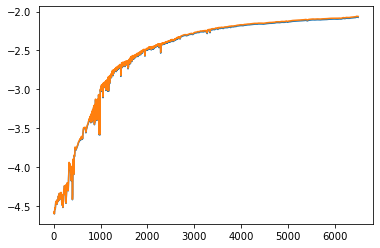

In [25]:
plt.plot(np.log10(_specs[200].cpu().detach().numpy()))
plt.plot(log_spec[200])

In [26]:
diff = (10**(log_spec) - _specs.cpu().detach().numpy()) / 10**log_spec * 100

(-20.0, 20.0)

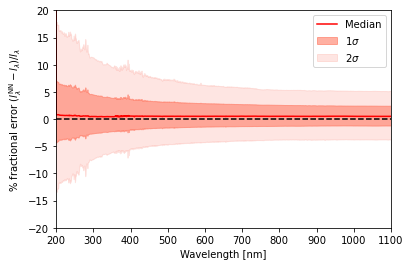

In [27]:
from scipy.stats import norm
x = wavelengths / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

plt.xlim(200, 1100)

plt.ylim(-20, 20)

In [28]:
_mags = speculator._predict_mag_with_mass_redshift(torch.Tensor(params).to('cuda'))

In [29]:
### real mags
lightspeed = 2.998e18  # AA/s
jansky_cgs = 1e-23

__spec = torch.Tensor(10**log_spec).to('cuda') * lightspeed / speculator.wave_obs**2 * (3631 * jansky_cgs)  # in cgs/AA units
__spec = torch.nan_to_num(__spec, 0.0)

maggies = torch.trapezoid(
    ((speculator.wave_obs * __spec)[:, None, :] * speculator.transmission_effiency[None, :, :]
    ), speculator.wave_obs) / speculator.ab_zero_counts

real_mags = -2.5 * torch.log10(maggies)

In [30]:
diff = (real_mags - _mags)/ real_mags * 100
diff = diff.cpu().detach().numpy()

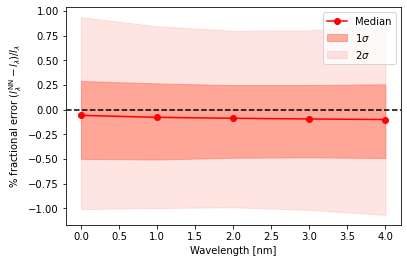

In [31]:
x = [0, 1, 2, 3, 4]
plt.plot(x, np.nanmedian(diff, axis=0), marker='o', color='r', label='Median')
plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.axhline(0, color='k', ls='--')
plt.legend()